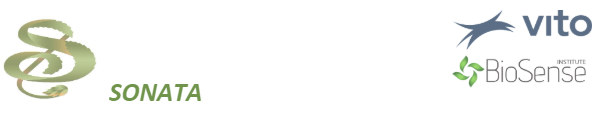
<br>
## training on VITO's hierarchical habitat mapping workflow for openEO processing platform
<br>
Copyrights, license and restrictions <br>
All code snippets, visualizations or/and workflow ideas are property of VITO. Work has been developed since 2021 and is still in development by VITO.
Showed public and private repositories are owned by VITO. <br>
(Re)sharing is only allowed with proper citation of the owners. Publications (peer-review, reports, ...) based partly and/or fully on VITO's hierarchical habitat mapping framework or on one of the provided GitHub repositories must be prior aligned with Dr. Marcel Buchhorn.
Code usage is allowed with proper citation, see author list in repository.
<br>
base repository: https://github.com/ESA-WEED-project/eo_processing

### Generation of full feature datacubes for Serbia via client-side block processing

In this notebook we generate the feature datacubes for the year 2024 which will be used to run the offline inference run for Serbia habitat map.


Note: since we are in the EU we use the developed openEO EU 20x20km processing grid which includes optimizes Sentinel-2 tile filters to reduce processing costs. Nevertheless, the approach also works globally by using the openEO global 20x20km processing grid.

IMPORTANT: this script is not needed anymore for habitat mapping inference. The openEO inference module generate the feature datacubes on-the-fly and apply all models on it. THIS SCRIPT IS ONLY FOR TRAINING PURPOSES.

original script by: Dr. Marcel Buchhorn <br>
adatped by: Lori Giagnacovo

In [1]:
# standard
from __future__ import annotations
import os
import geopandas as gpd
import pandas as pd
from typing import Optional, TYPE_CHECKING
import platform
import traceback
import openeo
from openeo.extra.job_management import CsvJobDatabase
from openeo.rest.datacube import THIS

# WEED project developments
from eo_processing.config import get_job_options, get_collection_options, get_standard_processing_options, generate_storage_options
from eo_processing.utils.helper import init_connection, location_visu, string_to_dict
from eo_processing.utils.jobmanager import WeedJobManager
from eo_processing.utils.storage import storage
from eo_processing.utils.messaging import send_email
from eo_processing.openeo.processing import generate_master_feature_cube
from eo_processing.utils.geoprocessing import AOI_tiler, bbox_area, geoJson_2_BBOX
from eo_processing.utils.metadata import get_base_metadata
from eo_processing.utils.jobmanager import get_AOI_interactive

if TYPE_CHECKING:
    from eo_processing.config.data_formats import storage_option_format

#### declaration area

Here we set all the needed parameters for the run.
Note: if data export to the S3 storage is needed THEN the user has to have access to the openEO "sonata-workspace" export workspace settings. If you also want then a local copy of the S3 saved file via the jobmanager THEN you have to initialize the `eo_processing` package `storage` object. So have the CloudFerro credentials by hand. <br>
If you do not want a local copy of the files then you can init the `storage` object empty and the script will still run.

Note: in this example we use the specific file_prefix also as s3_prefix for the storage on S3 in the result folder (if you want to run tests then please use the 'tests' s3_prefix).

In [2]:
# for the training we just selected an AOI - later just read in a GeoPanadas GeoDataFrame or other vector file for the AOI

file_name_base = 'feature-datacubes'
version_string = 'v1'
processing_year = 2024

# root output folder
root_base = os.path.normpath(r'C:\Users\BUCHHORM\Downloads')
out_root = os.path.join(root_base, f'features-cubes_{processing_year}')
os.makedirs(out_root, exist_ok=True)

# backend
backend = 'cdse'  # also possible: cdse-stagging
#### used for the training
sub_folder_in_test_S3 = 'Marcel'

# S3 storage for SONATA (since we do not need a local copy, we can init the storage object without credentials)
# if you want a local copy then hand over a dict in the s3_credential_format
s3_export = True     # set to False if no S3 export is wished -> then the following two parameters can be ignored)
s3_prefix = f'test/{sub_folder_in_test_S3}/{version_string}/{processing_year}' #that is the path to results in WEED bucket
local_copy_needed = False  # if you want a local copy to the output folder
sonata_storage = storage()

# run some overall functions
os.makedirs(out_root, exist_ok=True)
# set the storage options if we need S3 workspace export - if not specified then the standard local download is used in processing and jobmanager
storage_options = generate_storage_options(workspace_export=s3_export, S3_prefix=s3_prefix, local_S3_needed=local_copy_needed, storage=sonata_storage)

#### specify space context for the openEO run

The space context is set by intersecting the test sites (AOIs) with the openEO EU 20x20km tiling grid. We are using for this the new AOI_tiler. We use the keyword for the internal 20x20 km LAEA tiling grid for the EU.

In [3]:
get_AOI_interactive(map_center=(43, 20), zoom=11)

Please draw the AOI and press the EXPORT button.


In [5]:
AOI_bbox = geoJson_2_BBOX(os.path.join(root_base, 'polygon.geojson'), delete_file=True, size_check=600)
print(f"The bounding box is: {AOI_bbox} with an area of {bbox_area(AOI_bbox, only_number=True)} km2")

The bounding box is: {'west': 19.894867, 'south': 42.914195, 'east': 20.01709, 'north': 42.98054, 'crs': 'EPSG:4326'} with an area of 73.51720295472293 km2


In [6]:
# now the magic of tiling the AOI
gdf_aoi = AOI_tiler(AOI_bbox, 'EU')

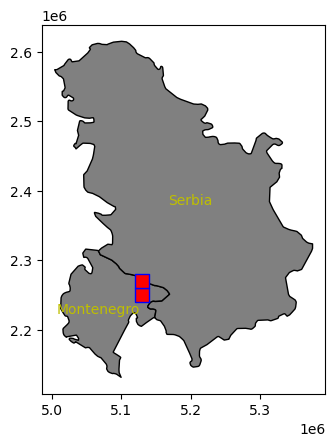

In [7]:
# visualization of the selected- tiles in the tiling grid which needs to be processed to cover the AOI
# we have to drop possible dupilcates of tiles since the location_visu function can not handle double tiles
location_visu(gdf_aoi.drop_duplicates(subset='name', keep='first'), zoom=True, region='EU', label=True)

#### Integration of the MultiBackendJobManager


##### creating the jobs dataframe

The MultiBackendJobManager uses a jobs database to set-up, start and monitor all desired jobs. We are using Pandas/GeoPandas to create a DataFrame storing the job and all parameters which should adapted for each job.

In this example we can directly use the GeoDataFrame of the tiling grid since after the intersection with the AOI is contains only the remaining block extents to process.

Note: for the inference we have to hand over also a lot of additional data to each job like: Model_URLs, list of output band names, ....

###### preparation of specific inference parameters

In [8]:
def create_job_dataframe(gdf: gpd.GeoDataFrame, year: int, file_name_base: str,
                         target_crs: Optional[int] = None, storage_options: Optional[storage_option_format] = None) -> gpd.GeoDataFrame:

    columns = ['name', 'tileID', 'target_epsg', 'bbox', 'file_prefix', 'start_date', 'end_date', 's3_prefix', 'geometry']
    dtypes = {'name': 'string', 'tileID': 'string', 'target_epsg': 'UInt16',
              'file_prefix': 'string', 'start_date': 'string', 'end_date': 'string',
              's3_prefix': 'string','geometry': 'geometry', 'bbox': 'string'}

    job_df = gdf.copy()

    # evaluate if tileID is given by 'name' or 'grid20id'
    if 'grid20id' in job_df.columns:
        tile_col = 'grid20id'
    else:
        tile_col = 'name'

    # the time context is given by start and end date
    job_df['start_date'] = f'{year}-01-01'
    job_df['end_date'] = f'{year+1}-01-01'  # the end is always exclusive

    # adding the output file name pre-fix
    job_df['file_prefix'] = job_df.apply(lambda row: f'{file_name_base}_feature-cube_year{year}_{row[tile_col]}', axis=1)

    # set the target epsg
    if target_crs is None:
        job_df['target_epsg'] = job_df.apply(lambda row: int(string_to_dict(row['bbox_dict'])['crs']), axis=1)
    else:
        job_df['target_epsg'] = target_crs

    job_df['bbox'] = job_df['bbox_dict']

    # set the s3_prefix which is needed for the path to S3 storage relative to SONATA bucket if we export
    if storage_options:
        job_df['s3_prefix'] = storage_options.get('S3_prefix', None)
    else:
        job_df['s3_prefix'] = None

    # a fix since the "name" column has to be unique
    job_df['tileID'] = job_df[tile_col].copy()
    job_df['name'] = job_df[tile_col] + f'_{year}'


    return job_df[columns].astype(dtypes)

In [9]:
# create job dataframe
job_df = create_job_dataframe(gdf_aoi, year=processing_year, file_name_base=f'{file_name_base}_{version_string}', storage_options=storage_options)
job_df.reset_index(drop=True, inplace=True)

In [10]:
# show the jobs_database before conversion into a JobDatabaseInterface
job_df.head()

,name,tileID,target_epsg,bbox,file_prefix,start_date,end_date,s3_prefix,geometry
0,E512N224_2024,E512N224,3035,"{'east': 5140000, 'south': 2240000, 'west': 51...",feature-datacubes_v1_feature-cube_year2024_E51...,2024-01-01,2025-01-01,test/Marcel/v1/2024,"MULTIPOLYGON (((19.7683 42.79878, 19.79799 42...."
1,E512N226_2024,E512N226,3035,"{'east': 5140000, 'south': 2260000, 'west': 51...",feature-datacubes_v1_feature-cube_year2024_E51...,2024-01-01,2025-01-01,test/Marcel/v1/2024,"MULTIPOLYGON (((19.79799 42.97762, 19.82792 43..."


In [11]:
print(f'Number of jobs to run: {job_df.shape[0]}')

Number of jobs to run: 2


##### creating the job start_job function

The next step is to define a start_job function. This function will instruct the MultiBackendJobManager on how to initiate a new job on the selected backend. The start_job functionality should adhere to the following structure start_job(row: pd.Series, connection: openeo.Connection, **kwargs).

Note: the start_job function can only use parameters which are hand over from the job_dataframe! Complex objects like the WEED_storage class can not be used therefore. Geometries can be serialized and stored in the Pandas/GeoPandas row as geojson.FeatureCollection.

In [12]:
def feature_datacube(row: gpd.GeoSeries, connection: openeo.Connection, provider: str , **kwgs) -> openeo.BatchJob:
    """Start a new job using the specified row out of the jobs GeoDataFrame and connection."""

    #### parameter section
    # extract needed parameters from the dataframe row
    tileID = row["tileID"]
    start = row["start_date"]
    end = row["end_date"]
    file_name = row["file_prefix"]
    epsg = int(row["target_epsg"])
    s3_prefix = row["s3_prefix"]

    # convert the row name into a openEO bbox dict giving the spatial extent of the job
    processing_extent = string_to_dict(row["bbox"])
    # define job_options, processing_options,  and collection_options
    job_options = get_job_options(provider=provider, task='feature_generation')
    collection_options = get_collection_options(provider=provider)
    processing_options = get_standard_processing_options(provider=provider, task='feature_generation')
    # adapt the epsg to the processing grid
    processing_options.update(target_crs = epsg)

    #### create the feature cube
    # define the S1/S2 processed feature cube (Note: do not set spatial extent since we hand it over in the end)
    data_cube = generate_master_feature_cube(connection,
                                             None,
                                             start,
                                             end,
                                             **collection_options,
                                             **processing_options)

    # now we merge in the NON ON-DEMAND processed features (DEM and WENR features)
    # load the DEM from a CDSE collection
    DEM = connection.load_collection(
        "COPERNICUS_30",
        bands=["DEM"])
    # reduce the temporal domain since copernicus_30 collection is "special" and feature only are one time stamp
    DEM = DEM.reduce_dimension(dimension='t', reducer=lambda x: x.last(ignore_nodata=True))
    # resample the cube to 10m and EPSG of corresponding 20x20km grid tile
    DEM = DEM.resample_spatial(projection=processing_options['target_crs'],
                               resolution=processing_options['resolution'],
                               method="bilinear")
    # merge into the S1/S2 data cube
    data_cube = data_cube.merge_cubes(DEM)

    # load the WERN features from public STAC
    WENR = connection.load_stac("https://stac.openeo.vito.be/collections/wenr_features")
    # resample the cube to 10m and EPSG of corresponding 20x20km grid tile
    WENR = WENR.resample_spatial(projection=processing_options['target_crs'],
                                 resolution=processing_options['resolution'],
                                 method="near")
    # drop the time dimension
    try:
        WENR = WENR.drop_dimension('t')
    except:
        # workaround if we still have the client issues with the time dimensions for STAC dataset with only one time stamp
        WENR.metadata = WENR.metadata.add_dimension("t", label=None, type="temporal")
        WENR = WENR.drop_dimension('t')
    # merge into the S1/S2 data cube
    data_cube = data_cube.merge_cubes(WENR)

    # filter spatial the whole cube
    data_cube = data_cube.filter_bbox(processing_extent)

    #### create job progress graph including storage to S3
    saved_cube = data_cube.save_result(format="GTiff",
                                        options={
                                            'separate_asset_per_band': False,   # set to False if a datacube
                                            # (Rasterstack with each band other feature) is desired,
                                            # set to True if datacube (one band/feature per GeoTIFF) is desired
                                            # (this facilitates export cause less heavy)
                                            'filename_prefix': file_name
                                        })
    if pd.isna(s3_prefix):
        cube_workspace = saved_cube
    else:
        cube_workspace = saved_cube.process("export_workspace",
                                            arguments={
                                                'data': THIS,
                                                'workspace': 'sonata-workspace',
                                                'merge': s3_prefix
                                            })
    job = cube_workspace.create_job(title=file_name,
                                    description=f'generation of full feature data cube for tile {tileID}',
                                    job_options=job_options)
    return job

###### run the jobs

With our jobs database and job definition set up, we can now run the jobs using the MultiBackendJobManager. This involves defining a path to where we will store the job tracker which contains the job statuses and metadata.

Note: If the specified job tracker path, points to an existing jobs database (either a .csv or .parquet file), that file will be used as the job tracker, and the input jobs database will be disregarded.

In [ ]:
#### IMPORTANT - for testing we only use the first two jobs
job_df = job_df.iloc[:2]
##### DELETE for production

In [13]:
# generate a unique name for the job tracker database (here: CSV file)
job_tracker = os.path.normpath(os.path.join(out_root, f'job_tracker_{file_name_base}_{version_string}_feature-cubes-openEO.csv'))
# init of MultiBackendJobManager (A viz switch has been added to enable vizualization of status)
manager = WeedJobManager(root_dir=out_root, poll_sleep=10, viz=True, storage_options=storage_options)
# create a connection to backend and add this active backend to the jobmanager
connection = init_connection(backend)
manager.add_backend(backend, connection=connection, parallel_jobs=2)

Authenticated using refresh token.


In [14]:
def reset_tracker_file(path_tracker: str) -> None:
    """
    Resets the statuses of jobs in a tracker file to allow reprocessing. The function reads a
    CSV file containing job information, modifies specific statuses, and writes the modified
    data back to the file. It identifies non-error and downloading-related statuses and updates
    them accordingly. A summary of the number of reset rows is printed to the console.

    :param path_tracker: Path to the tracker CSV file. The file is expected to have
        columns such as 'status' and 'attempt'.
    :return: None
    """
    count = 0
    df_tracker = pd.read_csv(path_tracker)
    non_error_statuses = ['created', 'queued', 'start_failed', 'skipped',
                          'canceled', 'error_openeo']
    # Iterate through each row in the DataFrame
    for index, row in df_tracker.iterrows():
        # check for the always downloaded job file to see if finished really means file is there
        # ToDO: implement the path generation for the json job file and check if exist on disk

        # Reset statuses for non-error-related jobs
        if row['status'] in non_error_statuses:
            df_tracker.at[index, 'status'] = 'not_started'
            count+=1
        # Reset statuses for downloading issues
        if row['status'] in ['error_downloading', 'downloading']:
            df_tracker.at[index, 'status'] = 'running'
            df_tracker.at[index, 'attempt'] = 1
            count+=1
    df_tracker.to_csv(path_tracker, index=False)
    print(f'overall {count} job rows in the tracker file were reset. You can manually restart the job processing.')

In [ ]:
# due to a bug in the JobManager class we first have to create the CSVJobDatabase by ourself and write it to disk so that we get all custom columns! Note: still loads existing one if no file exists on drive.
job_db = CsvJobDatabase(path=job_tracker)
if job_db.exists():
    print(f"Resuming `run_jobs` from existing {job_db}")
else:
    df = manager._normalize_df(job_df)
    job_db.persist(df)

# now start the jobs with the prepared JobDatabase object
try:
    manager.run_jobs(start_job=feature_datacube, job_db=job_db)
    send_email(path_recipients,
                   'feature cube generation SUCCESSFUL',
                   f'Processing successful. Data can be found here: {out_root}')
except Exception as e:
    tinfo = traceback.format_exc()
    send_email(path_recipients,
               'feature cube generation FAILED',
               f'Processing FAILED. Check error logs here: {out_root}\n\n{str(e)}\n\n{str(tinfo)}')
    print(str(e))
    print(tinfo)
    # reset the job_tracker file for the next run
    reset_tracker_file(job_tracker)

## about 30-40 min per tile

##### validate that all needed feature data cubes are generated

In [15]:
# load the job_tracker file into a pandas DataFrame
df_tracker = pd.read_csv(job_tracker)

In [16]:
# Check if all values in column "status" have the value "finished"
all_finished = df_tracker['status'].eq('finished').all()
if all_finished:
    print("All jobs are finished.")
else:
    print("Some jobs are not finished. Reset the non finished status rows to 'not_started' flag and restart the manager.run_jobs() line manually.")

All jobs are finished.


In [17]:
# print the costs of the full job
print(f'The feature generation for {df_tracker.shape[0]} 20x20km tiles has cost overall {df_tracker.cost.sum()} credits ({df_tracker.cost.sum() * 0.01} EURO). ')

The feature generation for 4 20x20km tiles has cost overall 243 credits (2.43 EURO). 
